In [9]:
from datasets import load_dataset
import pandas as pd

# 1. Téléchargement du dataset
# Le nom sur le hub est "dair-ai/emotion"
dataset = load_dataset("dair-ai/emotion")

# 2. Aperçu de la structure
print(dataset)

/home/lionel/DEVIA/NLP_/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [113]:
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    doc = nlp(text.lower())
    # On ajoute VERB (ex: hate, love) et ADV (ex: very, really)
    # On exclut les "stop words" de spaCy qui sont trop génériques
    allowed_pos = {"ADJ", "NOUN", "VERB", "ADV"}
    
    tokens = [
        token.lemma_ for token in doc 
        if (token.pos_ in allowed_pos or token.dep_ == "neg") 
        and not token.is_stop
    ]
    return " ".join(tokens)



In [114]:
clean_text("i didnt feel humiliated")

'not feel humiliated'

In [115]:
dataset_train = pd.DataFrame(dataset['train'])
dataset_test = pd.DataFrame(dataset['test'])
dataset_validation = pd.DataFrame(dataset['validation'])
dataset_train.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [116]:
from sklearn.utils import resample

# On sépare chaque classe
df_0 = dataset_train[dataset_train['label'] == 0]
df_1 = dataset_train[dataset_train['label'] == 1]
df_2 = dataset_train[dataset_train['label'] == 2]
df_3 = dataset_train[dataset_train['label'] == 3]
df_4 = dataset_train[dataset_train['label'] == 4]
df_5 = dataset_train[dataset_train['label'] == 5]

print(len(df_0))
print(len(df_1))
print(len(df_2))
print(len(df_3))
print(len(df_4))
print(len(df_5))


4666
5362
1304
2159
1937
572


In [117]:
from sklearn.utils import resample

# On cible 1300 exemples par classe
n_target = 1900

df_0_bal = resample(df_0, replace=False, n_samples=n_target, random_state=42)
df_1_bal = resample(df_1, replace=False, n_samples=n_target, random_state=42)
df_3_bal = resample(df_3, replace=False, n_samples=n_target, random_state=42)
df_4_bal = resample(df_4, replace=False, n_samples=n_target, random_state=42)

# Pour les petites (5) : on augmente (Oversampling simple)
df_2_bal = resample(df_2, replace=True, n_samples=n_target, random_state=42)
df_5_bal = resample(df_5, replace=True, n_samples=n_target, random_state=42)

# La classe 2 est déjà à 1304, on la garde telle quelle
df_balanced = pd.concat([df_0_bal, df_1_bal, df_2_bal, df_3_bal, df_4_bal, df_5_bal])

print(df_balanced['label'].value_counts())

label
0    1900
1    1900
2    1900
3    1900
4    1900
5    1900
Name: count, dtype: int64


In [118]:
df_balanced

,text,label
11433,im feeling so lousy they tried to cheer me up ...,0
9343,i feel highly disadvantaged,0
11833,i feel humiliated to introduce you to my colle...,0
88,i feel so worthless during those times i was s...,0
4119,i still miss him and feel rather weepy today,0
...,...,...
2044,i can remember what it feels like to be enthra...,5
10977,i cant help feeling curious you know after all...,5
6359,i have to care about and care for people with ...,5
15380,i have a feeling that my plant may have been t...,5


In [119]:
df_balanced['lemmas'] = df_balanced['text'].apply(clean_text)
dataset_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), 
    max_features=10000, # On garde uniquement le "top" du vocabulaire
    min_df=5,           # On ignore ce qui apparaît moins de 5 fois
    stop_words=None     # Crucial pour garder le "not"
)
X = vectorizer.fit_transform(df_balanced['lemmas'])

In [121]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=150)
df_balanced['predicted_label'] = kmeans.fit_predict(X)

df_balanced.head()

,text,label,lemmas,predicted_label
11433,im feeling so lousy they tried to cheer me up ...,0,feel lousy try cheer school time choir practice,4
9343,i feel highly disadvantaged,0,feel highly disadvantaged,3
11833,i feel humiliated to introduce you to my colle...,0,feel humiliated introduce colleague wife,3
88,i feel so worthless during those times i was s...,0,feel worthless time struggle find work,4
4119,i still miss him and feel rather weepy today,0,miss feel weepy today,3


In [122]:
from sklearn.decomposition import TruncatedSVD

# 1. Utiliser TruncatedSVD au lieu de PCA (mieux pour le texte)
# On choisit 3 composantes comme tu le souhaitais
svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(X) # X est ici ta matrice TF-IDF

# 2. On s'assure d'ajouter les coordonnées au BON DataFrame (df_balanced)
# Attention : utilise bien df_balanced car le nombre de lignes doit correspondre à X
df_balanced['x_coord'] = coords[:, 0]
df_balanced['y_coord'] = coords[:, 1]


print("Réduction de dimension terminée !")

Réduction de dimension terminée !


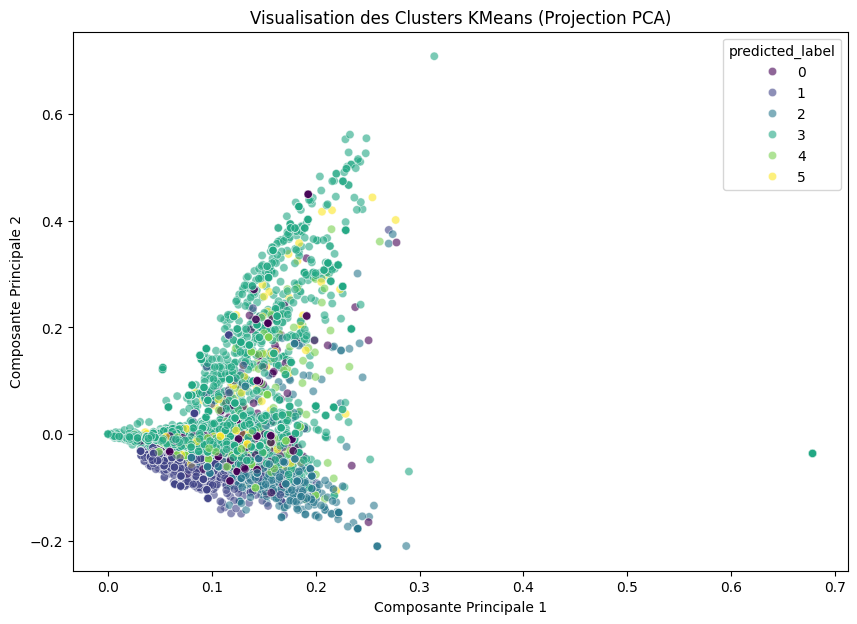

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='x_coord', y='y_coord', 
    hue='predicted_label', # Couleur par cluster
    data=df_balanced, 
    palette='viridis',      # Palette de 6 couleurs
    legend='full',
    alpha=0.6
)

plt.title('Visualisation des Clusters KMeans (Projection PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

In [124]:
terms = vectorizer.get_feature_names_out()

# Accéder aux centroïdes
centroids = kmeans.cluster_centers_

print("--- MOTS LES PLUS PROCHES DES CENTROÏDES ---")
for i in range(6):
    # On trie les indices des poids les plus forts pour le cluster i
    top_indices = centroids[i].argsort()[::-1][:15]
    
    print(f"\nCluster {i} :")
    # Affichage du mot avec son score de proximité (poids TF-IDF moyen)
    report = [f"{terms[ind]} ({centroids[i][ind]:.3f})" for ind in top_indices]
    print(" | ".join(report))

--- MOTS LES PLUS PROCHES DES CENTROÏDES ---

Cluster 0 :
go (0.181) | funny (0.076) | feel funny (0.063) | feel (0.056) | go feel (0.024) | feeling (0.021) | feel go (0.019) | little (0.016) | think (0.014) | not (0.014) | actually (0.013) | know (0.013) | love (0.013) | bit (0.013) | tell (0.013)

Cluster 1 :
feeling (0.211) | think (0.019) | get (0.018) | not (0.017) | get feeling (0.016) | love (0.014) | know (0.014) | feel (0.013) | time (0.012) | want (0.011) | like (0.011) | thing (0.011) | impressed (0.011) | long (0.011) | feeling not (0.009)

Cluster 2 :
not (0.202) | not feel (0.069) | feel (0.065) | know (0.033) | not know (0.029) | feel not (0.028) | not help (0.025) | want (0.023) | not want (0.023) | help (0.021) | help feel (0.019) | people (0.012) | think (0.012) | thing (0.012) | like (0.011)

Cluster 3 :
feel (0.075) | little (0.013) | know (0.011) | bit (0.011) | love (0.010) | think (0.010) | want (0.010) | feel little (0.009) | people (0.009) | feel bit (0.009) | 

In [125]:

# On récupère le mot le plus "central" pour chaque cluster
for i in range(6):
    index_central = kmeans.cluster_centers_[i].argmax()
    mot_central = terms[index_central]
    poids_central = kmeans.cluster_centers_[i][index_central]
    
    print(f"Cluster {i} : Le mot 'pilier' est '{mot_central}' (Poids : {poids_central:.4f})")

Cluster 0 : Le mot 'pilier' est 'go' (Poids : 0.1814)
Cluster 1 : Le mot 'pilier' est 'feeling' (Poids : 0.2114)
Cluster 2 : Le mot 'pilier' est 'not' (Poids : 0.2018)
Cluster 3 : Le mot 'pilier' est 'feel' (Poids : 0.0751)
Cluster 4 : Le mot 'pilier' est 'time' (Poids : 0.1460)
Cluster 5 : Le mot 'pilier' est 'day' (Poids : 0.1705)


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Préparation des données (Assurez-vous d'utiliser vos lemmas nettoyés)
# On transforme les listes de mots en chaînes de caractères
X_train = df_balanced['lemmas']
y_train = df_balanced['label']
X_test = dataset_test['text'].apply(clean_text)
y_test = dataset_test['label']


# 3. Vectorisation (Crucial : Bigrammes activés pour le "not")
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Modèle Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Prédictions
y_pred = model.predict(X_test_tfidf)

In [127]:
print("--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_test, y_pred))

--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       581
           1       0.91      0.87      0.89       695
           2       0.70      0.67      0.68       159
           3       0.78      0.88      0.82       275
           4       0.73      0.84      0.78       224
           5       0.70      0.74      0.72        66

    accuracy                           0.84      2000
   macro avg       0.79      0.81      0.80      2000
weighted avg       0.85      0.84      0.84      2000



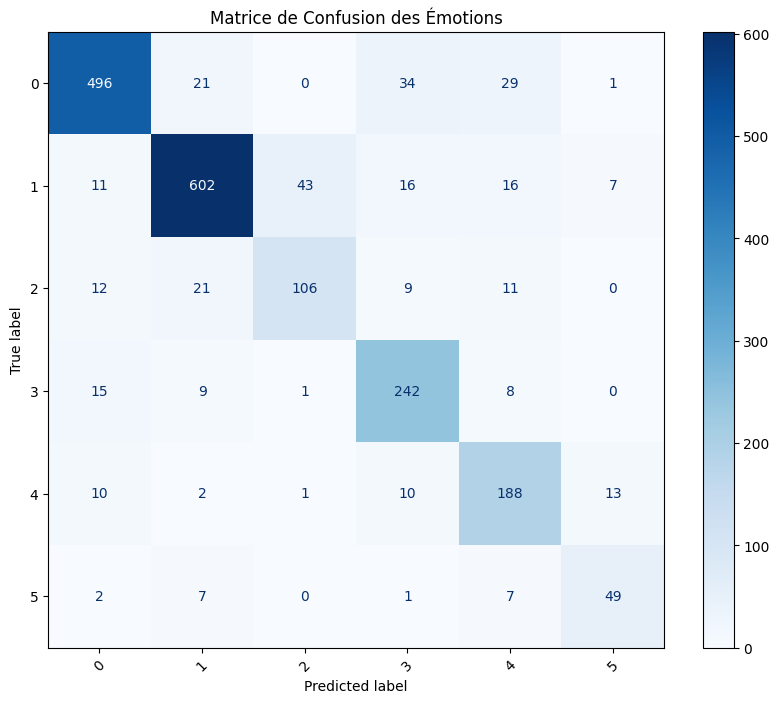

In [128]:
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Matrice de Confusion des Émotions")
plt.show()

In [129]:
test_phrases = [
    "I am overwhelmed with happiness because everything is finally perfect.",
    "It is hard to get out of bed when everything feels so heavy and hopeless.",
    "The way you support me makes me feel so loved and cherished.",
    "I am absolutely fuming! How could they be so incredibly disrespectful?",
    "My heart is racing and I am terrified of what might happen in the dark.",
    "Wow, I am stunned! I never expected this to happen so suddenly.",
    "I am not feeling very glad right now.",
    "This is not a bad day at all."
]
clean_txt_phrases = [clean_text(text) for text in test_phrases]
test_tfidf = vectorizer.transform(clean_txt_phrases)
predictions = model.predict(test_tfidf)

for phrase, pred in zip(test_phrases, predictions):
    print(f"Phrase: '{phrase}' --> Émotion prédite: {pred}")

Phrase: 'I am overwhelmed with happiness because everything is finally perfect.' --> Émotion prédite: 1
Phrase: 'It is hard to get out of bed when everything feels so heavy and hopeless.' --> Émotion prédite: 0
Phrase: 'The way you support me makes me feel so loved and cherished.' --> Émotion prédite: 2
Phrase: 'I am absolutely fuming! How could they be so incredibly disrespectful?' --> Émotion prédite: 0
Phrase: 'My heart is racing and I am terrified of what might happen in the dark.' --> Émotion prédite: 4
Phrase: 'Wow, I am stunned! I never expected this to happen so suddenly.' --> Émotion prédite: 5
Phrase: 'I am not feeling very glad right now.' --> Émotion prédite: 1
Phrase: 'This is not a bad day at all.' --> Émotion prédite: 0


In [130]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Préparation (XGBoost a besoin de labels commençant à 0)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 2. Vectorisation (On garde ta logique de bigrammes)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.3, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 3. Configuration du modèle XGBoost
# On utilise 'multi:softmax' pour obtenir directement la classe prédite
model_xgb = xgb.XGBClassifier(
    n_estimators=100,      # Nombre d'arbres
    learning_rate=0.1,     # Vitesse d'apprentissage
    max_depth=6,           # Profondeur des arbres (capture des interactions)
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42
)

# 4. Entraînement
model_xgb.fit(X_train_tfidf, y_train_encoded)

# 5. Prédictions
y_pred_encoded = model_xgb.predict(X_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded) # On revient aux labels d'origine

--- RAPPORT DE CLASSIFICATION (XGBOOST) ---
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       581
           1       0.81      0.87      0.84       695
           2       0.63      0.83      0.72       159
           3       0.87      0.84      0.85       275
           4       0.88      0.83      0.86       224
           5       0.58      0.95      0.72        66

    accuracy                           0.83      2000
   macro avg       0.79      0.85      0.81      2000
weighted avg       0.85      0.83      0.84      2000



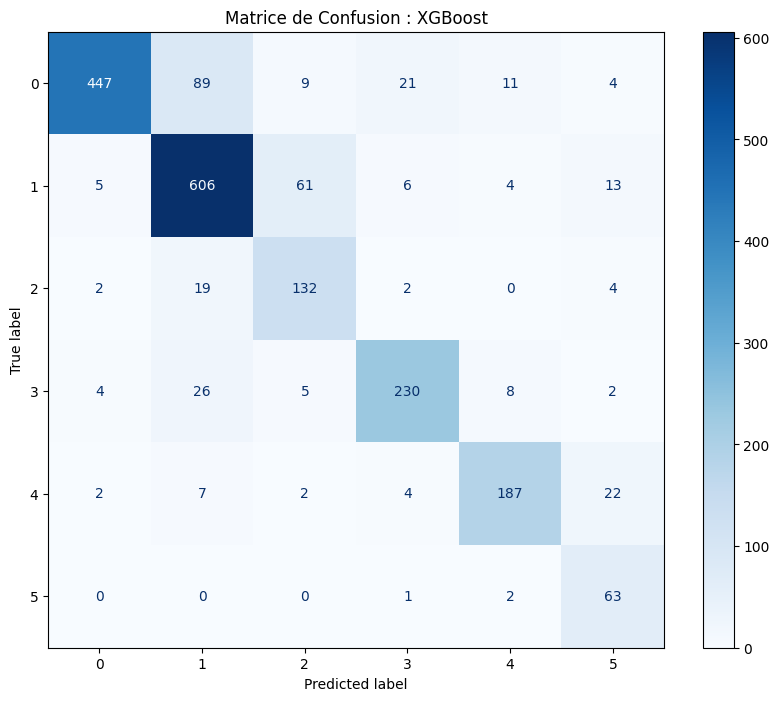

In [131]:
print("--- RAPPORT DE CLASSIFICATION (XGBOOST) ---")
print(classification_report(y_test, y_pred))

# Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title("Matrice de Confusion : XGBoost")
plt.show()

In [132]:
import pandas as pd

emotion_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# On crée un DataFrame de comparaison sur le jeu de test
df_missed = pd.DataFrame({
    'Phrase': dataset_test.loc[X_test.index, 'text'],
    'Vraie_Emotion': y_test.map(emotion_dict),
    'Prediction_IA': pd.Series(y_pred, index=y_test.index).map(emotion_dict)
})

# On ne garde que les lignes où la prédiction est fausse
df_missed = df_missed[df_missed['Vraie_Emotion'] != df_missed['Prediction_IA']]

# Affichons les 10 premières erreurs pour analyse
print(f"Nombre total d'erreurs : {len(df_missed)}")
display(df_missed.head(10))

Nombre total d'erreurs : 335


,Phrase,Vraie_Emotion,Prediction_IA
6,i felt anger when at the end of a telephone call,anger,joy
7,i explain why i clung to a relationship with a...,joy,love
10,i don t feel particularly agitated,fear,anger
20,im not sure the feeling of loss will ever go a...,sadness,love
34,i feel like i m defective or something for not...,sadness,joy
36,i feel very honoured to be included in a magzi...,joy,surprise
53,i can t stop the anxiety i feel when i m alone...,sadness,joy
56,i had every intention of doing more gardening ...,sadness,joy
62,i spent wandering around still kinda dazed and...,joy,surprise
86,i feel like i am in paradise kissing those swe...,joy,love


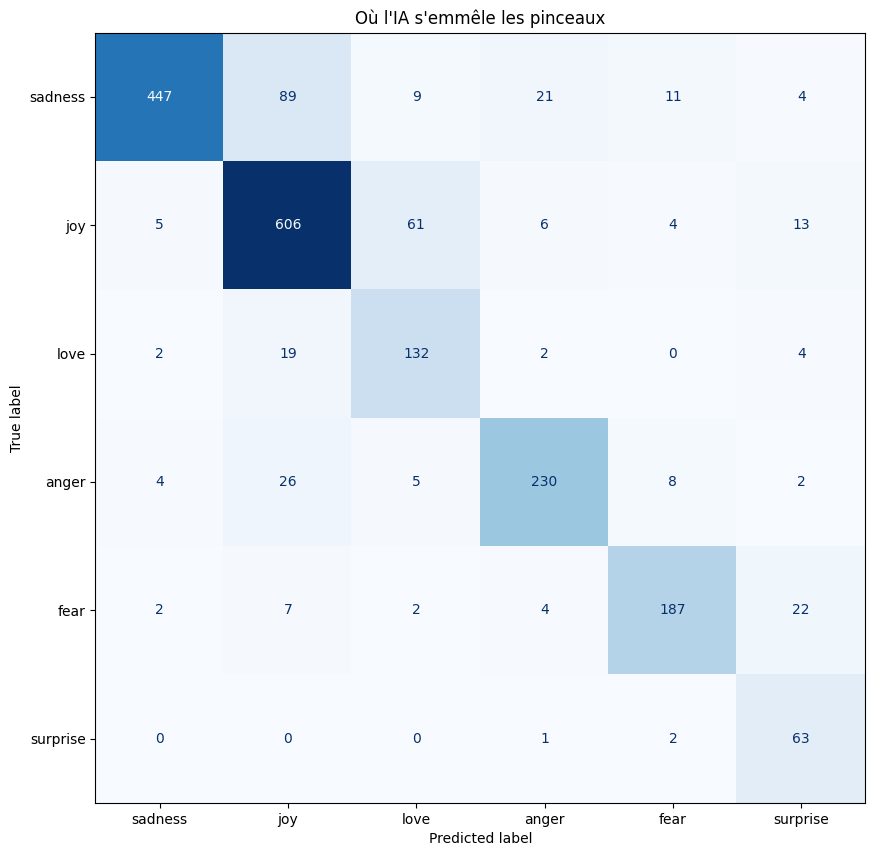

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Utilise ton dictionnaire d'émotions pour les labels
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=labels, 
    cmap='Blues', 
    ax=ax, 
    colorbar=False
)
plt.title("Où l'IA s'emmêle les pinceaux")
plt.show()

In [134]:
X_train = dataset_train['text'].apply(clean_text)
X_test = dataset_test['text'].apply(clean_text)

In [135]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight

# 1. Chargement de spaCy
# On désactive le 'parser' et le 'ner' pour gagner énormément en vitesse
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except:
    import en_core_web_sm
    nlp = en_core_web_sm.load()

# 2. Tokenizer personnalisé utilisant la lemmatisation de spaCy
def spacy_tokenizer(text):
    doc = nlp(text.lower())
    # On garde les racines (lemmes) et on retire ponctuation/espaces
    # On garde les mots comme 'not' car ils sont cruciaux pour l'émotion
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

# 3. Préparation des données (Remplace par tes variables si besoin)
y_train = dataset_train['label']
y_test = dataset_test['label']

# 4. Création du Pipeline LinearSVC
# Ce modèle est souvent plus performant que XGBoost sur du texte court
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=spacy_tokenizer, 
        ngram_range=(1, 2),
        max_features=15000, # Un peu moins de features pour forcer la généralisation
        min_df=5,           # On ignore les "fautes de frappe" uniques
        token_pattern=None
    )),
    ('clf', xgb.XGBClassifier(
        n_estimators=1000,     # Plus d'arbres
        max_depth=15,          # Plus profond
        learning_rate=0.1,    # Apprentissage plus rapide
        subsample=1.0,        # On utilise toutes les données pour chaque arbre
        colsample_bytree=1.0, 
        random_state=42
    ))
])

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 3. Entraîne ton pipeline avec ces poids
# Note : fit() prend les sample_weight pour le classifieur (clf)

# 5. Entraînement
print("Entraînement en cours (Lemmatisation spaCy + XGBOOST)...")
pipeline.fit(X_train, y_train, clf__sample_weight=sample_weights)

# Score sur les données d'entraînement
train_score = pipeline.score(X_train, y_train)

# Score sur les données de test (que tu as déjà probablement)
test_score = pipeline.score(X_test, y_test)

print(f"Score d'entraînement (Train Accuracy) : {train_score:.2%}")
print(f"Score de test (Test Accuracy) : {test_score:.2%}")
print(f"Écart (Gap) : {(train_score - test_score):.2%}")

Entraînement en cours (Lemmatisation spaCy + XGBOOST)...
Score d'entraînement (Train Accuracy) : 99.40%
Score de test (Test Accuracy) : 87.65%
Écart (Gap) : 11.75%


In [136]:
y_pred = pipeline.predict(X_test)

--- RAPPORT DE CLASSIFICATION (XGBOOST) ---
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       581
           1       0.91      0.90      0.90       695
           2       0.71      0.77      0.74       159
           3       0.91      0.88      0.89       275
           4       0.81      0.84      0.83       224
           5       0.66      0.82      0.73        66

    accuracy                           0.88      2000
   macro avg       0.82      0.85      0.83      2000
weighted avg       0.88      0.88      0.88      2000



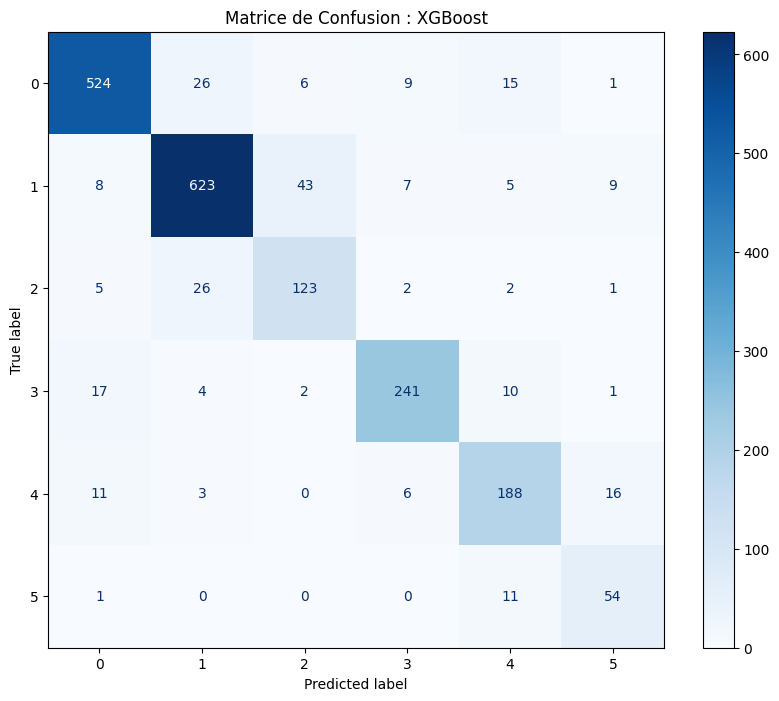

In [137]:
print("--- RAPPORT DE CLASSIFICATION (XGBOOST) ---")
print(classification_report(y_test, y_pred))

# Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title("Matrice de Confusion : XGBoost")
plt.show()